# Setup

In [6]:
import os, glob, math, re, random
from collections import defaultdict
import numpy as np
import pandas as pd

import cv2
from PIL import Image
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

# Kaggle tip: set this to your dataset folder, e.g.
# DATA_ROOT = '/kaggle/input/microscopic-image-dataset-of-plant-parasitic-nematodes/Microscopic Image Dataset of Plant-Parasitic Nematodes'
DATA_ROOT = r'/kaggle/input/datasets/parvazemahmud/dataset-of-plant-parasitic-nematodes'

# If running locally (this sandbox), you can point to extracted folder:
# DATA_ROOT = r'/mnt/data/nematodes_dataset/Microscopic Image Dataset of Plant-Parasitic Nematodes'

assert os.path.exists(DATA_ROOT), f"DATA_ROOT not found: {DATA_ROOT}"

CLASS_DIR_PREFIX = "Genus "
IMAGE_EXTS = ('.jpg','.jpeg','.png','.bmp','.tif','.tiff','.webp')

def list_images(data_root=DATA_ROOT):
    rows = []

    for root, dirs, files in os.walk(data_root):
        for f in files:
            if f.lower().endswith(IMAGE_EXTS):
                full_path = os.path.join(root, f)

                # Extract genus name from folder
                folder = os.path.basename(os.path.dirname(full_path))
                cls = folder.replace("Genus", "").strip()

                rows.append({
                    "path": full_path,
                    "class": cls,
                    "class_dir": folder,
                    "fname": f
                })

    return pd.DataFrame(rows)

In [7]:
df = list_images()

print("Images:", len(df))
print("Classes:", df['class'].nunique())
print(df.head())

Images: 1016
Classes: 11
                                                path        class  \
0  /kaggle/input/datasets/parvazemahmud/dataset-o...  Meloidogyne   
1  /kaggle/input/datasets/parvazemahmud/dataset-o...  Meloidogyne   
2  /kaggle/input/datasets/parvazemahmud/dataset-o...  Meloidogyne   
3  /kaggle/input/datasets/parvazemahmud/dataset-o...  Meloidogyne   
4  /kaggle/input/datasets/parvazemahmud/dataset-o...  Meloidogyne   

           class_dir                  fname  
0  Genus Meloidogyne   Meloidogyne (59).jpg  
1  Genus Meloidogyne  Meloidogyne (181).jpg  
2  Genus Meloidogyne  Meloidogyne (104).jpg  
3  Genus Meloidogyne  Meloidogyne (118).jpg  
4  Genus Meloidogyne   Meloidogyne (47).jpg  


# Class balance

,n_images
class,
Meloidogyne,211
Hoplolaimus,151
Helicotylenchus,135
Hirschmaniella,130
Pratylenchus,116
Criconemoides,103
Xiphinema,85
Trichodorus,44
Radopholus,31


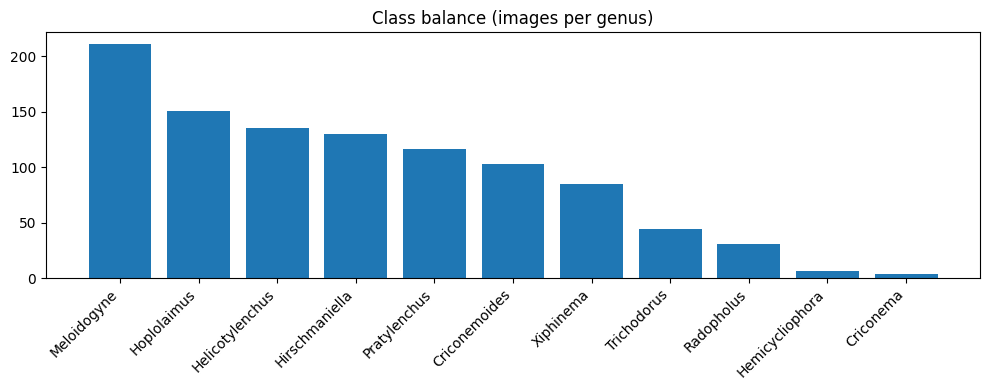

In [8]:
class_counts = df['class'].value_counts().sort_values(ascending=False)

display(class_counts.to_frame('n_images'))

plt.figure(figsize=(10,4))
plt.bar(class_counts.index, class_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title("Class balance (images per genus)")
plt.tight_layout()
plt.show()

# Fast per-image metrics

In [9]:
def read_bgr(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Could not read: {path}")
    return img

def rgb_hsv_stats(bgr):
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)

    # channel means/stds
    rgb_mean = rgb.reshape(-1,3).mean(axis=0)
    rgb_std  = rgb.reshape(-1,3).std(axis=0)

    hsv_mean = hsv.reshape(-1,3).mean(axis=0)
    hsv_std  = hsv.reshape(-1,3).std(axis=0)

    # brightness/contrast via V channel
    v = hsv[...,2].astype(np.float32)
    brightness = float(v.mean())
    contrast   = float(v.std())

    # clipping proxies (fractions at extremes)
    s = hsv[...,1]
    sat_clip_low  = float((s <= 5).mean())
    sat_clip_high = float((s >= 250).mean())
    v_clip_low    = float((hsv[...,2] <= 5).mean())
    v_clip_high   = float((hsv[...,2] >= 250).mean())

    return rgb_mean, rgb_std, hsv_mean, hsv_std, brightness, contrast, sat_clip_low, sat_clip_high, v_clip_low, v_clip_high

def sharpness_noise_stats(bgr):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    # (iii) Sharpness: Laplacian variance
    lap = cv2.Laplacian(gray, cv2.CV_64F)
    lap_var = float(lap.var())

    # light noise proxy: std of high-frequency residual
    blur = cv2.GaussianBlur(gray, (0,0), sigmaX=1.2)
    resid = (gray.astype(np.float32) - blur.astype(np.float32))
    noise_proxy = float(resid.std())
    return lap_var, noise_proxy

def gray_world_score(bgr):
    # (iv) Gray-world: channel means should be similar in well-balanced lighting
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB).astype(np.float32)
    m = rgb.reshape(-1,3).mean(axis=0) + 1e-6
    # normalize by average
    avg = m.mean()
    ratios = m / avg  # ideally close to [1,1,1]
    # score = mean absolute deviation from 1
    score = float(np.mean(np.abs(ratios - 1.0)))
    return score, ratios

rows=[]
for p, cls in tqdm(df[['path','class']].itertuples(index=False), total=len(df)):
    bgr = read_bgr(p)
    h,w = bgr.shape[:2]
    rgb_mean, rgb_std, hsv_mean, hsv_std, bright, contr, s_lo, s_hi, v_lo, v_hi = rgb_hsv_stats(bgr)
    lap_var, noise_proxy = sharpness_noise_stats(bgr)
    gw_score, gw_ratios = gray_world_score(bgr)

    rows.append({
        "path": p, "class": cls, "h": h, "w": w,
        "aspect": w / h,
        "rgb_mean_r": rgb_mean[0], "rgb_mean_g": rgb_mean[1], "rgb_mean_b": rgb_mean[2],
        "rgb_std_r": rgb_std[0],   "rgb_std_g": rgb_std[1],   "rgb_std_b": rgb_std[2],
        "hsv_mean_h": hsv_mean[0], "hsv_mean_s": hsv_mean[1], "hsv_mean_v": hsv_mean[2],
        "hsv_std_h": hsv_std[0],   "hsv_std_s": hsv_std[1],   "hsv_std_v": hsv_std[2],
        "brightness_v_mean": bright,
        "contrast_v_std": contr,
        "sat_clip_low": s_lo, "sat_clip_high": s_hi,
        "val_clip_low": v_lo, "val_clip_high": v_hi,
        "lap_var": lap_var,
        "noise_proxy": noise_proxy,
        "grayworld_score": gw_score,
        "grayworld_r_ratio": gw_ratios[0],
        "grayworld_g_ratio": gw_ratios[1],
        "grayworld_b_ratio": gw_ratios[2],
    })

m = pd.DataFrame(rows)
m.head()

  0%|          | 0/1016 [00:00<?, ?it/s]

,path,class,h,w,aspect,rgb_mean_r,rgb_mean_g,rgb_mean_b,rgb_std_r,rgb_std_g,...,sat_clip_low,sat_clip_high,val_clip_low,val_clip_high,lap_var,noise_proxy,grayworld_score,grayworld_r_ratio,grayworld_g_ratio,grayworld_b_ratio
0,/kaggle/input/datasets/parvazemahmud/dataset-o...,Meloidogyne,1024,1280,1.25,118.014413,122.217127,116.749119,16.328130,16.070660,...,0.041283,0.000153,3.051758e-06,0.000002,415.663787,6.219346,0.018096,0.991730,1.027144,0.981126
1,/kaggle/input/datasets/parvazemahmud/dataset-o...,Meloidogyne,1024,1280,1.25,128.200169,136.981505,128.146940,12.614967,14.734054,...,0.010534,0.000011,0.000000e+00,0.000000,128.551101,3.387141,0.029899,0.977943,1.044849,0.977209
2,/kaggle/input/datasets/parvazemahmud/dataset-o...,Meloidogyne,1024,1280,1.25,125.495848,133.696443,131.368326,14.675457,15.942913,...,0.017593,0.000022,0.000000e+00,0.000005,145.528916,3.635653,0.023975,0.964037,1.026993,1.008970
3,/kaggle/input/datasets/parvazemahmud/dataset-o...,Meloidogyne,1024,1280,1.25,115.434171,118.655069,113.349745,18.123768,18.745817,...,0.024403,0.000026,0.000000e+00,0.000039,199.715968,4.232145,0.016378,0.996714,1.024566,0.978720
4,/kaggle/input/datasets/parvazemahmud/dataset-o...,Meloidogyne,1024,1280,1.25,108.272332,118.741573,106.914604,12.073058,15.315568,...,0.033712,0.000810,7.629395e-07,0.000000,147.540481,3.871692,0.044363,0.973135,1.066545,0.960320


# RGB + HSV histograms

  0%|          | 0/250 [00:00<?, ?it/s]

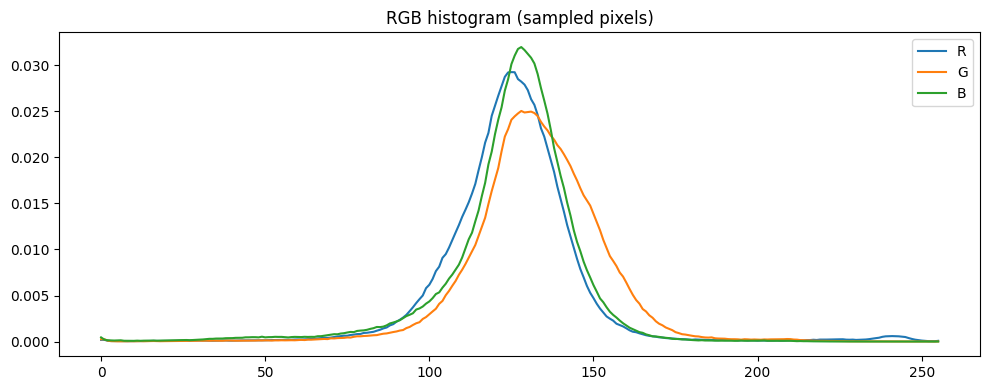

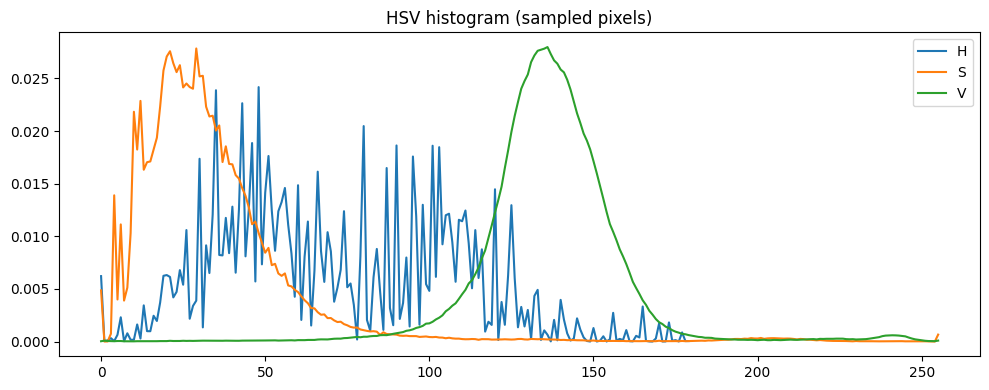

In [10]:
def hist_channel(values, bins=256, range_=(0,255)):
    h, _ = np.histogram(values, bins=bins, range=range_, density=True)
    return h

# Sample pixels (for speed) - you can increase N_SAMPLES if needed
N_SAMPLES = 2_000_000
rng = np.random.default_rng(123)

pix_rgb = []
pix_hsv = []
for p in tqdm(df['path'].sample(min(len(df), 250), random_state=0), total=min(len(df),250)):
    bgr = read_bgr(p)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    flat_rgb = rgb.reshape(-1,3)
    flat_hsv = hsv.reshape(-1,3)
    take = min(len(flat_rgb), 5000)
    idx = rng.choice(len(flat_rgb), size=take, replace=False)
    pix_rgb.append(flat_rgb[idx])
    pix_hsv.append(flat_hsv[idx])

pix_rgb = np.vstack(pix_rgb)
pix_hsv = np.vstack(pix_hsv)

plt.figure(figsize=(10,4))
for i, ch in enumerate(['R','G','B']):
    plt.plot(hist_channel(pix_rgb[:,i]), label=ch)
plt.title("RGB histogram (sampled pixels)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
for i, ch in enumerate(['H','S','V']):
    rng_ = (0,179) if ch=='H' else (0,255)
    bins = 180 if ch=='H' else 256
    h, _ = np.histogram(pix_hsv[:,i], bins=bins, range=rng_, density=True)
    plt.plot(h, label=ch)
plt.title("HSV histogram (sampled pixels)")
plt.legend()
plt.tight_layout()
plt.show()

# Per-image & per-class mean/std + brightness/contrast + saturation clipping

,n,rgb_mean_r,rgb_mean_g,rgb_mean_b,rgb_std_r,rgb_std_g,rgb_std_b,hsv_mean_s,hsv_mean_v,brightness,contrast,sat_clip_low,sat_clip_high
class,,,,,,,,,,,,,
Meloidogyne,211,126.489,133.276,124.919,17.028,19.270,17.046,37.761,138.613,138.613,17.049,0.021,0.003
Hoplolaimus,151,125.696,132.954,127.353,17.332,18.612,17.505,32.764,137.284,137.284,17.088,0.025,0.001
Helicotylenchus,135,126.215,133.230,120.389,15.370,17.159,14.581,39.472,138.047,138.047,15.794,0.020,0.001
Hirschmaniella,130,123.455,132.492,125.612,14.270,16.550,15.014,34.533,136.365,136.365,14.696,0.019,0.001
Pratylenchus,116,122.538,130.813,121.219,14.015,16.245,14.283,36.305,134.499,134.499,14.770,0.020,0.001
Criconemoides,103,123.195,132.652,125.293,15.599,17.297,15.333,32.938,135.730,135.730,15.727,0.023,0.001
Xiphinema,85,127.286,133.810,124.919,14.616,16.752,15.582,35.626,138.238,138.238,14.874,0.022,0.001
Trichodorus,44,132.100,132.129,122.114,15.598,17.045,15.006,32.989,138.163,138.163,15.414,0.044,0.002
Radopholus,31,146.780,140.644,112.062,14.831,15.615,13.654,59.877,151.632,151.632,14.048,0.033,0.001


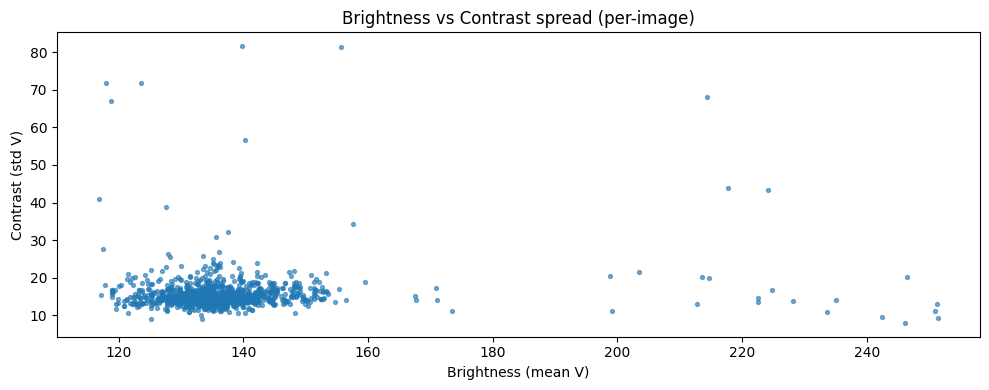

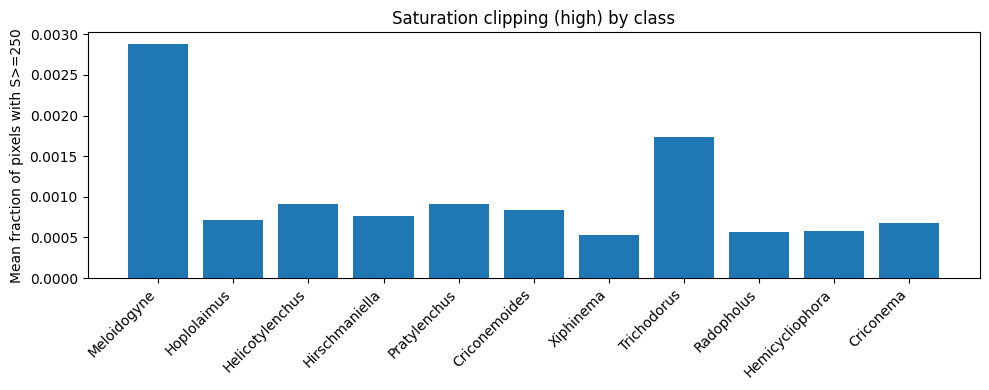

In [11]:
per_class = m.groupby('class').agg(
    n=('path','size'),
    rgb_mean_r=('rgb_mean_r','mean'),
    rgb_mean_g=('rgb_mean_g','mean'),
    rgb_mean_b=('rgb_mean_b','mean'),
    rgb_std_r=('rgb_std_r','mean'),
    rgb_std_g=('rgb_std_g','mean'),
    rgb_std_b=('rgb_std_b','mean'),
    hsv_mean_s=('hsv_mean_s','mean'),
    hsv_mean_v=('hsv_mean_v','mean'),
    brightness=('brightness_v_mean','mean'),
    contrast=('contrast_v_std','mean'),
    sat_clip_low=('sat_clip_low','mean'),
    sat_clip_high=('sat_clip_high','mean'),
).sort_values('n', ascending=False)

display(per_class.round(3))

# brightness/contrast spread (per-image)
plt.figure(figsize=(10,4))
plt.scatter(m['brightness_v_mean'], m['contrast_v_std'], s=8, alpha=0.6)
plt.xlabel("Brightness (mean V)")
plt.ylabel("Contrast (std V)")
plt.title("Brightness vs Contrast spread (per-image)")
plt.tight_layout()
plt.show()

# saturation clipping per class
plt.figure(figsize=(10,4))
plt.bar(per_class.index, per_class['sat_clip_high'])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean fraction of pixels with S>=250")
plt.title("Saturation clipping (high) by class")
plt.tight_layout()
plt.show()

# Resolution + aspect ratio distributions

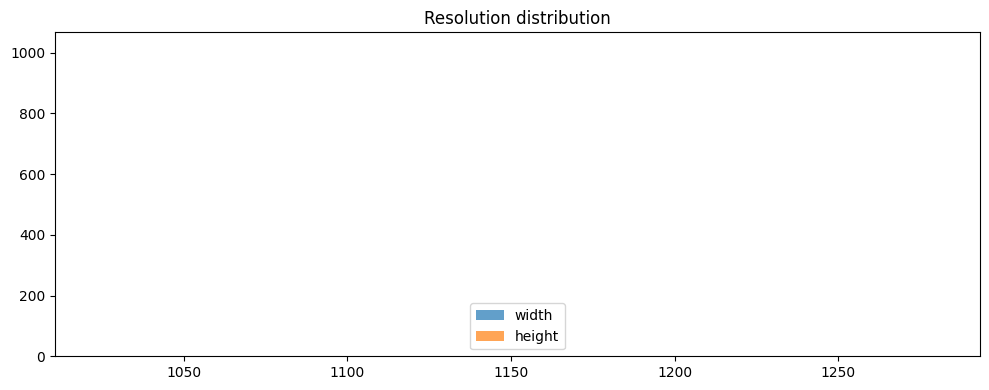

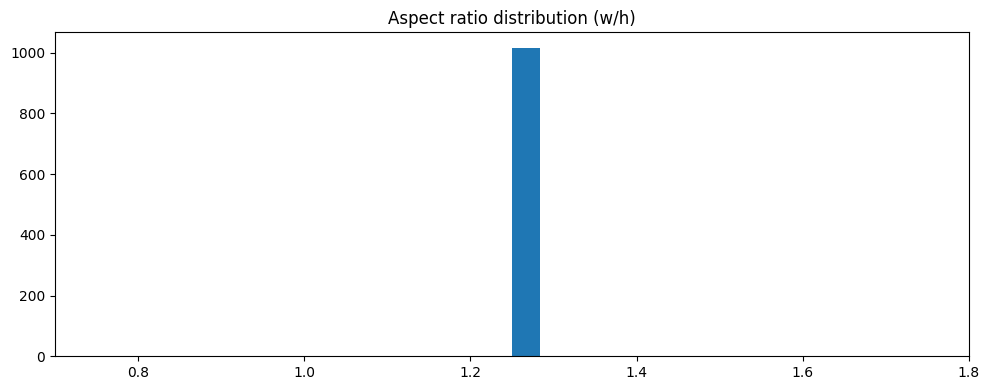

/tmp/ipykernel_126/628537158.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=classes, showfliers=False)


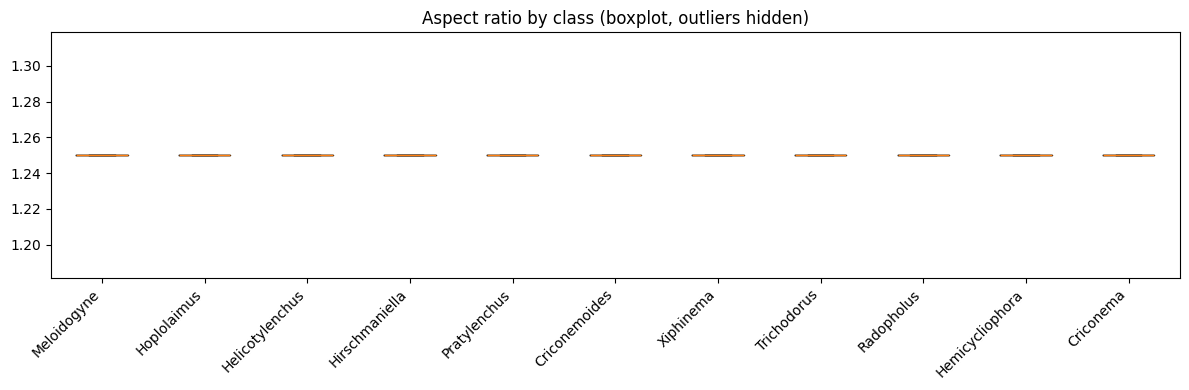

In [12]:
plt.figure(figsize=(10,4))
plt.hist(m['w'], bins=30, alpha=0.7, label='width')
plt.hist(m['h'], bins=30, alpha=0.7, label='height')
plt.title("Resolution distribution")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.hist(m['aspect'], bins=30)
plt.title("Aspect ratio distribution (w/h)")
plt.tight_layout()
plt.show()

# class-wise aspect ratio effect (boxplot-style with simple matplotlib)
classes = list(per_class.index)
data = [m.loc[m['class']==c, 'aspect'].values for c in classes]
plt.figure(figsize=(12,4))
plt.boxplot(data, labels=classes, showfliers=False)
plt.xticks(rotation=45, ha='right')
plt.title("Aspect ratio by class (boxplot, outliers hidden)")
plt.tight_layout()
plt.show()

# Recommended resizing/padding strategy

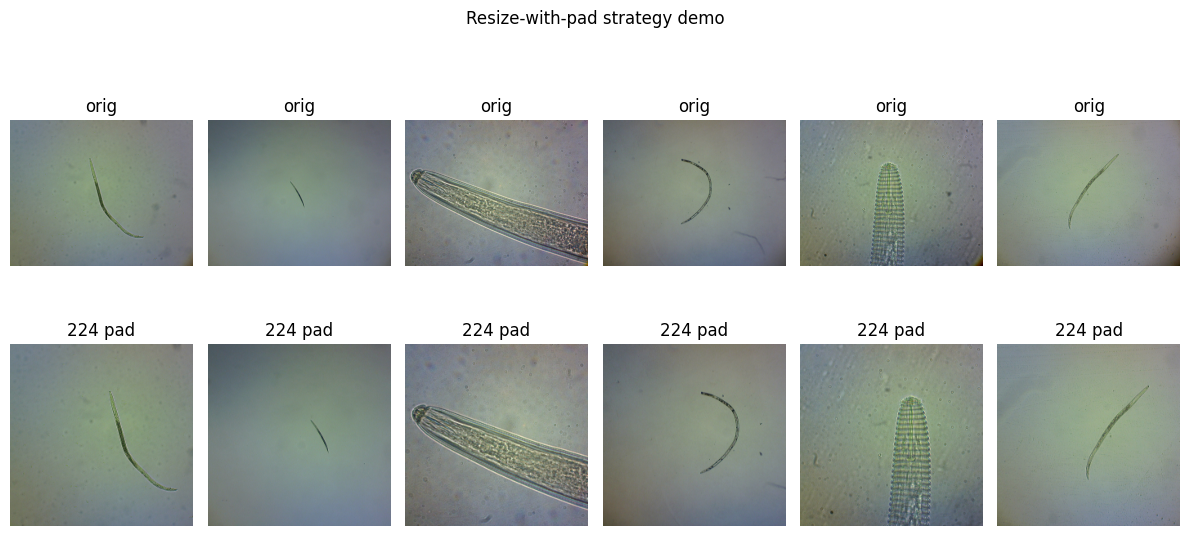

In [13]:
def resize_with_pad(img_rgb, target=224):
    h,w = img_rgb.shape[:2]
    scale = target / min(h,w)
    nh, nw = int(round(h*scale)), int(round(w*scale))
    resized = cv2.resize(img_rgb, (nw, nh), interpolation=cv2.INTER_AREA)
    # center pad
    top = (target - nh)//2 if nh < target else 0
    bottom = target - nh - top if nh < target else 0
    left = (target - nw)//2 if nw < target else 0
    right = target - nw - left if nw < target else 0
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    # If both sides became > target due to rounding, center-crop
    padded = padded[:target, :target]
    return padded, (h,w), (padded.shape[0], padded.shape[1]), (scale, top, bottom, left, right)

# Visual sanity: show original vs padded for a few random images
sample_paths = df.sample(6, random_state=1)['path'].tolist()
plt.figure(figsize=(12,6))
for i,p in enumerate(sample_paths,1):
    bgr = read_bgr(p)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    out, *_ = resize_with_pad(rgb, target=224)
    plt.subplot(2,6,i)
    plt.imshow(rgb); plt.axis('off'); plt.title("orig")
    plt.subplot(2,6,i+6)
    plt.imshow(out); plt.axis('off'); plt.title("224 pad")
plt.suptitle("Resize-with-pad strategy demo")
plt.tight_layout()
plt.show()

# Sharpness (Laplacian variance) + noise proxy

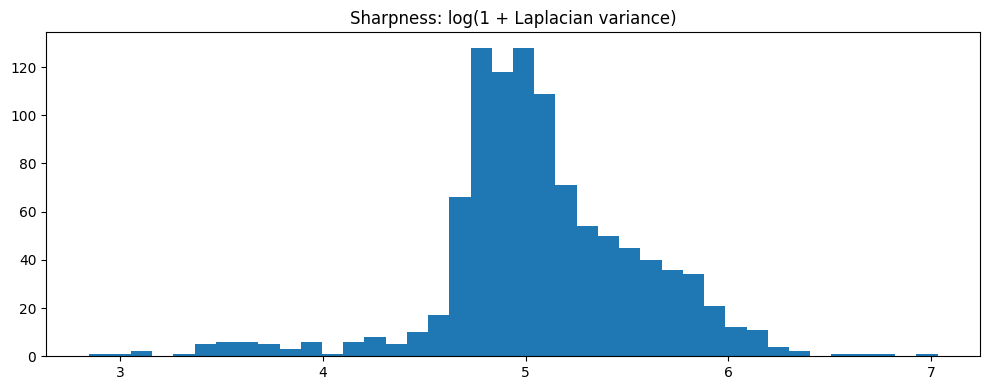

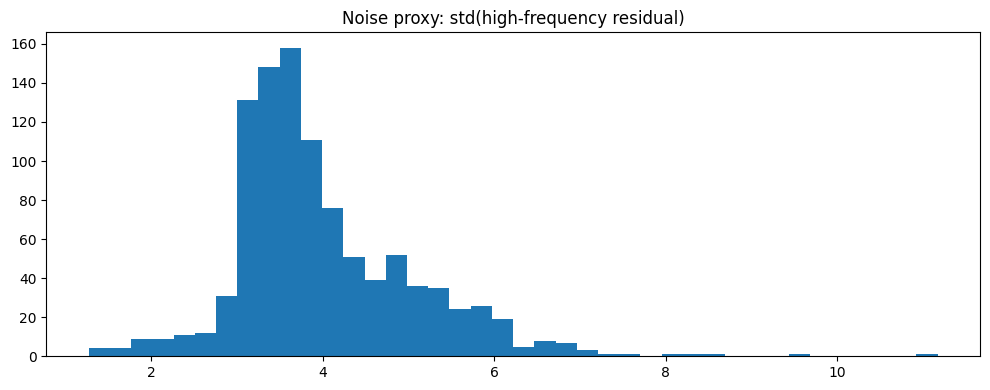

,lap_var_med,lap_var_iqr,noise_med
class,,,
Hoplolaimus,201.530,164.641,4.434
Criconemoides,162.580,89.211,3.903
Hirschmaniella,156.972,98.464,3.821
Hemicycliophora,156.109,85.690,3.721
Pratylenchus,154.406,66.157,3.731
Meloidogyne,152.308,76.734,3.731
Helicotylenchus,143.103,58.926,3.621
Xiphinema,138.738,108.863,3.549
Criconema,127.281,58.021,3.449


In [14]:
plt.figure(figsize=(10,4))
plt.hist(np.log1p(m['lap_var']), bins=40)
plt.title("Sharpness: log(1 + Laplacian variance)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.hist(m['noise_proxy'], bins=40)
plt.title("Noise proxy: std(high-frequency residual)")
plt.tight_layout()
plt.show()

# Quick per-class summary
sharp_noise = m.groupby('class').agg(
    lap_var_med=('lap_var','median'),
    lap_var_iqr=('lap_var', lambda x: np.percentile(x,75)-np.percentile(x,25)),
    noise_med=('noise_proxy','median'),
).sort_values('lap_var_med', ascending=False)
display(sharp_noise.round(3))

# White-balance sanity via Gray-World check

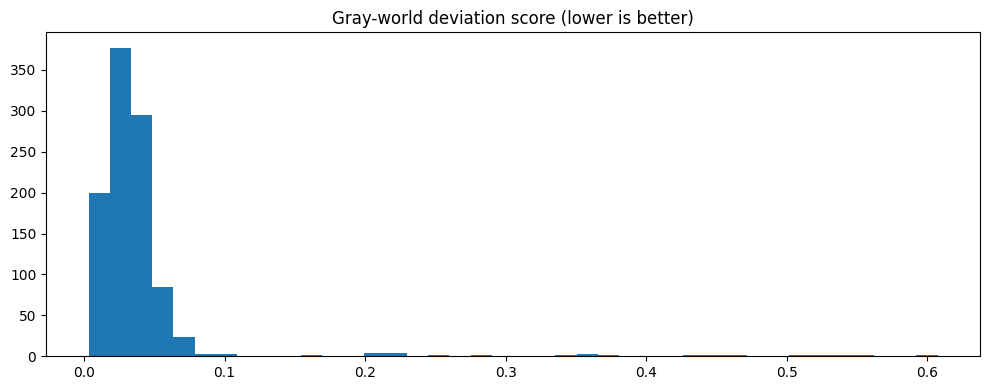

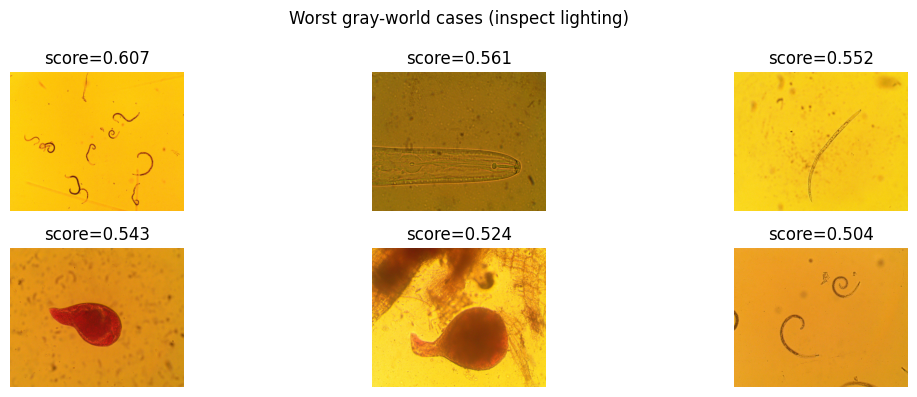

In [15]:
plt.figure(figsize=(10,4))
plt.hist(m['grayworld_score'], bins=40)
plt.title("Gray-world deviation score (lower is better)")
plt.tight_layout()
plt.show()

# Show a few worst-balanced images
worst = m.sort_values('grayworld_score', ascending=False).head(6)
plt.figure(figsize=(12,4))
for i,(p,score) in enumerate(zip(worst['path'], worst['grayworld_score']),1):
    bgr = read_bgr(p)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    plt.subplot(2,3,i)
    plt.imshow(rgb); plt.axis('off')
    plt.title(f"score={score:.3f}")
plt.suptitle("Worst gray-world cases (inspect lighting)")
plt.tight_layout()
plt.show()

# Duplicate detection using perceptual hashing (pHash)

In [16]:
def phash(img_rgb, hash_size=8, highfreq_factor=4):
    # convert to grayscale and resize
    img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    size = hash_size * highfreq_factor
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
    img = np.float32(img)
    dct = cv2.dct(img)
    dctlow = dct[:hash_size, :hash_size]
    med = np.median(dctlow[1:,:])  # skip DC-ish bias
    bits = (dctlow > med).astype(np.uint8)
    return bits.flatten()

def hamming(a,b):
    return int(np.count_nonzero(a != b))

# Compute hashes
hashes=[]
for p in tqdm(df['path'], total=len(df)):
    bgr = read_bgr(p)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    hashes.append(phash(rgb))
hashes = np.stack(hashes)

# Find duplicates using a simple bucketing: exact match first, then near-match within distance<=4 inside bucket
# Bucket by first 16 bits to reduce comparisons
bucket = defaultdict(list)
for i,h in enumerate(hashes):
    key = tuple(h[:16].tolist())
    bucket[key].append(i)

pairs=[]
DIST_TH = 4
for key, idxs in bucket.items():
    if len(idxs) < 2:
        continue
    for a_i in range(len(idxs)):
        for b_i in range(a_i+1, len(idxs)):
            ia, ib = idxs[a_i], idxs[b_i]
            d = hamming(hashes[ia], hashes[ib])
            if d <= DIST_TH:
                pairs.append((ia, ib, d))

print("Near-duplicate pairs found (<=4):", len(pairs))
pairs[:10]

  0%|          | 0/1016 [00:00<?, ?it/s]

Near-duplicate pairs found (<=4): 2368


[(4, 39, 4),
 (4, 220, 4),
 (4, 244, 4),
 (4, 248, 4),
 (4, 273, 4),
 (4, 276, 4),
 (4, 278, 2),
 (4, 282, 4),
 (4, 291, 4),
 (4, 293, 2)]

# Build duplicate clusters (union-find) and summarize

Clusters with size>1: 39


,cluster_size
dup_cluster,
755,94
914,17
382,10
288,6
960,4
749,3
841,3
337,3
861,3



Cluster 755 size 94


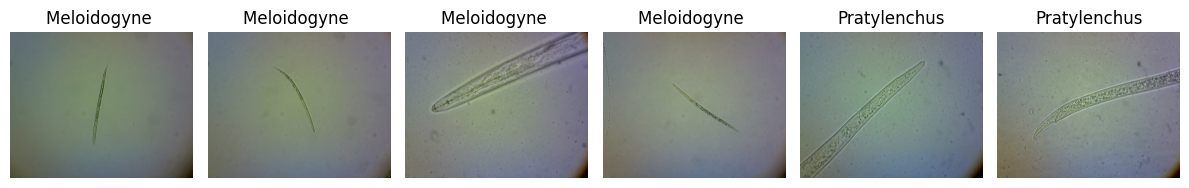


Cluster 914 size 17


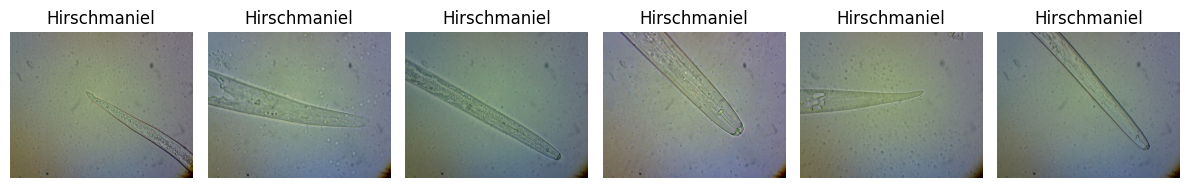


Cluster 382 size 10


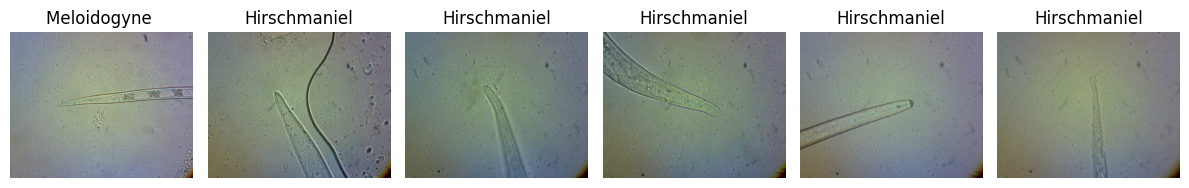

In [17]:
parent = list(range(len(df)))
def find(x):
    while parent[x]!=x:
        parent[x]=parent[parent[x]]
        x=parent[x]
    return x
def union(a,b):
    ra, rb = find(a), find(b)
    if ra!=rb:
        parent[rb]=ra

for ia, ib, d in pairs:
    union(ia, ib)

cluster_id = [find(i) for i in range(len(df))]
df['dup_cluster'] = cluster_id
m['dup_cluster'] = cluster_id

cluster_sizes = df.groupby('dup_cluster').size().sort_values(ascending=False)
print("Clusters with size>1:", (cluster_sizes>1).sum())
display(cluster_sizes.head(10).to_frame('cluster_size'))

# Show a few example duplicate clusters
example_clusters = cluster_sizes[cluster_sizes>1].head(3).index.tolist()
for cid in example_clusters:
    paths = df.loc[df['dup_cluster']==cid,'path'].tolist()
    print("\nCluster", cid, "size", len(paths))
    plt.figure(figsize=(12,3))
    for i,p in enumerate(paths[:6],1):
        rgb = cv2.cvtColor(read_bgr(p), cv2.COLOR_BGR2RGB)
        plt.subplot(1,6,i)
        plt.imshow(rgb); plt.axis('off')
        plt.title(os.path.basename(p)[:12])
    plt.tight_layout()
    plt.show()

# Class balance already shown; add imbalance ratio

In [18]:
imbalance_ratio = class_counts.max() / class_counts.min()
print("Imbalance ratio (max/min):", float(imbalance_ratio))

# Optional: compute effective number of samples
beta = 0.999
eff_num = 1 - np.power(beta, class_counts.values)
eff_num = (1-beta) / eff_num
eff_df = pd.DataFrame({"class": class_counts.index, "n": class_counts.values, "effective_weight": eff_num})
display(eff_df)

Imbalance ratio (max/min): 52.75


,class,n,effective_weight
0,Meloidogyne,211,0.005255
1,Hoplolaimus,151,0.007132
2,Helicotylenchus,135,0.007915
3,Hirschmaniella,130,0.008199
4,Pratylenchus,116,0.009126
5,Criconemoides,103,0.010212
6,Xiphinema,85,0.012266
7,Trichodorus,44,0.023220
8,Radopholus,31,0.032745
9,Hemicycliophora,6,0.167084


# Leakage safeguards in splitting

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

# Build cluster-level table
cluster_tbl = df.groupby('dup_cluster').agg(
    n=('path','size'),
    # if a cluster ever spans multiple classes, that's a red flag; we record it.
    classes=('class', lambda x: sorted(set(x))),
    cls=('class', lambda x: x.value_counts().index[0]) # majority label
).reset_index()

cluster_tbl['n_classes'] = cluster_tbl['classes'].apply(len)
print("Clusters spanning >1 class:", int((cluster_tbl['n_classes']>1).sum()))
display(cluster_tbl[cluster_tbl['n_classes']>1].head(10))

# Stratified split on clusters (train/val/test = 70/15/15)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, temp_idx = next(sss1.split(cluster_tbl, cluster_tbl['cls']))
train_clusters = set(cluster_tbl.iloc[train_idx]['dup_cluster'])
temp = cluster_tbl.iloc[temp_idx].reset_index(drop=True)

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=42)  # half of 30% => 15%
val_idx, test_idx = next(sss2.split(temp, temp['cls']))
val_clusters = set(temp.iloc[val_idx]['dup_cluster'])
test_clusters = set(temp.iloc[test_idx]['dup_cluster'])

def assign_split(dup_cluster):
    if dup_cluster in train_clusters: return "train"
    if dup_cluster in val_clusters: return "val"
    return "test"

df['split'] = df['dup_cluster'].apply(assign_split)
print(df['split'].value_counts())

# Verify class distribution per split
split_counts = df.pivot_table(index='class', columns='split', values='path', aggfunc='count', fill_value=0)
display(split_counts)

Clusters spanning >1 class: 13


,dup_cluster,n,classes,cls,n_classes
96,99,2,"[Hirschmaniella, Meloidogyne]",Meloidogyne,2
161,166,2,"[Meloidogyne, Pratylenchus]",Meloidogyne,2
182,187,2,"[Meloidogyne, Pratylenchus]",Meloidogyne,2
237,250,2,"[Hirschmaniella, Pratylenchus]",Pratylenchus,2
267,288,6,"[Hirschmaniella, Pratylenchus, Trichodorus]",Hirschmaniella,3
281,309,2,"[Hoplolaimus, Pratylenchus]",Pratylenchus,2
296,328,2,"[Hirschmaniella, Pratylenchus]",Pratylenchus,2
301,337,3,"[Hirschmaniella, Trichodorus]",Hirschmaniella,2
338,382,10,"[Criconemoides, Hirschmaniella, Meloidogyne]",Hirschmaniella,3
637,749,3,"[Hoplolaimus, Trichodorus]",Trichodorus,2


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

# Augmentation probe: safe vs harmful

In [20]:
import torch
import torchvision.transforms as T
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
model.eval()
# remove classification head => feature vector
feat_model = torch.nn.Sequential(*(list(model.children())[:-1])).to(device).eval()

pre = models.ResNet18_Weights.DEFAULT.transforms()

def get_feat(img_rgb):
    pil = Image.fromarray(img_rgb)
    x = pre(pil).unsqueeze(0).to(device)
    with torch.no_grad():
        f = feat_model(x).squeeze().cpu().numpy()
    f = f / (np.linalg.norm(f) + 1e-9)
    return f

# Define augmentation candidates
augs = {
    "hflip": T.RandomHorizontalFlip(p=1.0),
    "vflip": T.RandomVerticalFlip(p=1.0),
    "random_crop": T.RandomResizedCrop(224, scale=(0.7, 1.0), ratio=(0.9, 1.1)),
    "color_jitter": T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    "gauss_blur": T.GaussianBlur(kernel_size=7, sigma=(0.1, 2.0)),
}

def apply_aug(img_rgb, aug):
    pil = Image.fromarray(img_rgb)
    pil = aug(pil)
    # Ensure size reasonable for embedding transform pipeline
    pil = pil.resize((224,224), resample=Image.BILINEAR)
    return np.array(pil)

# Probe on a stratified sample
sample_per_class = 15
probe_rows=[]
for cls in class_counts.index:
    sub = df[df['class']==cls].sample(min(sample_per_class, (df['class']==cls).sum()), random_state=0)
    for p in sub['path']:
        rgb = cv2.cvtColor(read_bgr(p), cv2.COLOR_BGR2RGB)
        base = get_feat(cv2.resize(rgb,(224,224)))
        for name, aug in augs.items():
            aug_img = apply_aug(rgb, aug)
            f = get_feat(aug_img)
            sim = float(np.dot(base, f))
            probe_rows.append({"class":cls, "aug":name, "cos_sim":sim})

probe = pd.DataFrame(probe_rows)

# Summarize: higher cosine similarity => safer (label preserved)
summary = probe.groupby('aug')['cos_sim'].agg(['mean','std','min','max']).sort_values('mean', ascending=False)
display(summary.round(4))

plt.figure(figsize=(10,4))
for name in augs.keys():
    plt.hist(probe.loc[probe['aug']==name,'cos_sim'], bins=25, alpha=0.5, label=name)
plt.title("Augmentation probe: cosine similarity distributions")
plt.xlabel("cosine similarity (ResNet18 embedding)")
plt.legend()
plt.tight_layout()
plt.show()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


URLError: <urlopen error [Errno -3] Temporary failure in name resolution>